# Tanzania Waterpoint Analysis by Region

<br>
<br>
<br>
<br>
<br>
<br>

## Modeling Water Point Dataset:

In [16]:
#%pip install sodapy

In [92]:
#Imports:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer 
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier
#import geopandas as gpd  
#from sodapy import Socrata


In [61]:
#Reading in waterpoint csv:
df = pd.read_csv('./data/og_water_data.csv')
target = pd.read_csv('./data/og_water_target.csv')
sub_test = pd.read_csv('./data/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [3]:
#Checking for nulls in training set:
df.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [4]:
#df EDA:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [5]:
#df EDA:
df['population'].mean()

179.90998316498317

In [6]:
#df EDA:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [7]:
#df EDA:
target['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [8]:
#DF quick descriptive stats:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [9]:
len(target['status_group']), len(df['id'])

(59400, 59400)

In [10]:
df_joined = pd.concat([df,target], axis=1)

In [12]:
#Temp split for logreg coef interpretation analysis of numerical features only:
X1 = df_joined.drop(columns = ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type','subvillage','installer',
                              'funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group',
                              'payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 
                              'status_group' , 'longitude' , 'latitude' , 'date_recorded', 'region_code', 'district_code'])
y1 = df_joined['status_group']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, stratify = y1, random_state=123)

In [13]:
#Temp LR model for interpretability of numerical features:
lr1 = LogisticRegression(max_iter=10000)
lr1.fit(X_train1,y_train1)
lr1.score(X_train1,y_train1),lr1.score(X_test1,y_test1)

(0.5395735129068462, 0.5443771043771044)

In [14]:
lr1.coef_

array([[ 1.04263029e-04,  1.64644889e-04,  6.48190384e-04,
         1.46525503e-05, -1.53345521e-05],
       [ 7.95576405e-05,  7.43987155e-05, -2.51016709e-04,
         5.30817793e-05, -1.58296812e-04],
       [-1.83820669e-04, -2.39043605e-04, -3.97173672e-04,
        -6.77343296e-05,  1.73631365e-04]])

In [15]:
#Creating numerical df coefficient dataframe:
numerical_coef_df = pd.DataFrame(np.exp(lr1.coef_).T)
numerical_coef_df['features'] = list(X_train1.columns)
numerical_coef_df = numerical_coef_df.set_index('features')
numerical_coef_df.sort_values(by=[0],ascending=True)

,0,1,2
features,,,
construction_year,0.999985,0.999842,1.000174
population,1.000015,1.000053,0.999932
amount_tsh,1.000104,1.000080,0.999816
gps_height,1.000165,1.000074,0.999761
num_private,1.000648,0.999749,0.999603


In [62]:
#Temp split for logreg coef interpretation analysis of 251 feature set only:
X = df_joined.drop(columns = ['subvillage','installer','funder','ward','scheme_name','wpt_name','waterpoint_type_group','extraction_type_group','payment_type','quantity_group','source_type','source_class','extraction_type_class','id', 'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y = df_joined['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=123)

ct1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','permit']),],
                         remainder='passthrough',verbose_feature_names_out = False)            

train_si = ct1.fit_transform(X_train)
train_si = pd.DataFrame(train_si, columns=X_train.columns)
test_si = ct1.transform(X_test)
test_si = pd.DataFrame(test_si, columns=X_test.columns)
sub_test_si = ct1.transform(sub_test)
sub_test_si = pd.DataFrame(sub_test_si, columns=X_test.columns)


ct2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','public_meeting','recorded_by',
                         'scheme_management','permit','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False)  


In [65]:
#Encoding categorical variables for temp interpretation model:
train_enc = ct2.fit_transform(X_train)
train_enc = pd.DataFrame(train_enc, columns = ct2.get_feature_names_out())
test_enc = ct2.transform(X_test)
test_enc = pd.DataFrame(test_enc, columns = ct2.get_feature_names_out())
sub_test_enc = ct2.transform(sub_test)
sub_test_enc = pd.DataFrame(sub_test_enc, columns = ct2.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [66]:
#Standard Scaler for temp interpretation model:
ss = StandardScaler()
X_train_sc = ss.fit_transform(train_enc)
X_train_sc = pd.DataFrame(X_train_sc, columns = ss.get_feature_names_out())
X_test_sc = ss.transform(test_enc)
X_test_sc = pd.DataFrame(X_test_sc, columns = ss.get_feature_names_out())
sub_test_sc = ss.transform(sub_test_enc)
sub_test_sc = pd.DataFrame(sub_test_sc, columns = ss.get_feature_names_out())

In [20]:
#Temp LR model for interpretability of numerical features:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_sc,y_train)
lr.score(X_train_sc,y_train),lr.score(X_test_sc,y_test)

(0.753557800224467, 0.7412794612794613)

In [21]:
#Creating df of categorical coefficient:
coef_df = pd.DataFrame(np.exp(lr.coef_).T)
coef_df['features'] = list(X_train_sc.columns)
coef_df = coef_df.set_index('features')
coef_df.sort_values(by=[1],ascending=False)[:50]

,0,1,2
features,,,
lga_Bariadi,0.886359,1.311749,0.860081
gps_height,1.014508,1.199649,0.821657
lga_Masasi,0.916884,1.173829,0.929139
lga_Ngara,0.987305,1.166720,0.868125
source_river,0.927256,1.161582,0.928433
lga_Bukombe,0.936251,1.160031,0.920742
lga_Dodoma Urban,0.988451,1.155723,0.875369
lga_Mpanda,0.893752,1.145283,0.976946
extraction_type_gravity,0.919670,1.142962,0.951340


In [22]:
#Code for inspecting this dataframe for most/least weighted coefs:
coef_df.sort_values(by=[1],ascending=True)[:50]

,0,1,2
features,,,
lga_Makete,1.241102,0.685100,1.176085
lga_Hanang,1.155460,0.749674,1.154443
quantity_dry,0.562316,0.759330,2.342012
lga_Kongwa,1.263305,0.761603,1.039352
lga_Muheza,1.198395,0.766675,1.088401
lga_Sengerema,1.133298,0.778849,1.132929
lga_Chato,1.091700,0.781107,1.172697
lga_Bagamoyo,1.144324,0.790296,1.105761
lga_Ilala,1.106941,0.799679,1.129691


In [23]:
# #Resulting accuracy scores for models with different recombinations of largest 5 features:
#Train/Test Accuracy Scores for models without (Funder, Installer, Sub-Village, Ward, and Scheme):
# LR: (0.753557800224467, 0.7412794612794613)
# KNC: (0.8229405162738496, 0.7527272727272727)
# RFC: (0.9443322109988777, 0.7858585858585858)
# ABC: (0.7265319865319866, 0.7211447811447812)
# VC: (0.9443097643097643, 0.784983164983165) Voting classifier performs worse than Random Forest alone.

#Train/Test Accuracy Scores for models WITH (scheme_name): ... one less, three more.
# LR: (0.7933557800224467, 0.7634343434343435)
# KNC: (0.8197081930415264, 0.7530639730639731)
# RFC: (0.9507519640852974, 0.7861952861952862)
# ABC: (0.7277665544332211, 0.721010101010101)

#Train/Test Accuracy Scores for models WITH (installer): generally less.
# LR: (0.7780022446689113, 0.750976430976431)
# KNC: (0.8174859708193042, 0.7471380471380471)
# RFC: (0.9517396184062851, 0.7875420875420875)
# ABC: (0.7253872053872054, 0.7177777777777777)

#Train/Test Accuracy Scores for models WITH (funder): ...generally less.
# LR: (0.7769248035914702, 0.7520538720538721)b
# KNC: (0.819685746352413, 0.7438383838383839)
# RFC: (0.9541638608305275, 0.7885521885521886)
# ABC: (0.7284175084175084, 0.7206734006734007)

#Train/Test Accuracy Scores for models WITH (ward): ...two less, two more.
# LR: (0.7947923681257014, 0.7604713804713805)
# KNC: (0.8122783389450056, 0.7359595959595959)
# RFC: (0.9614590347923682, 0.7890235690235691)
# ABC: (0.7245342312008979, 0.7188552188552189)

#Train/Test Accuracy Scores for models WITH (ward, funder, installer, scheme_name): ...one less, three more.
# LR: (0.8453198653198654, 0.7688888888888888)
# KNC: (0.8050729517396185, 0.7255218855218856)
# RFC: (0.969023569023569, 0.7913804713804714)
# ABC: (0.7307295173961841, 0.7228282828282828)

#Train/Test Accuracy Scores for models WITH (ward, installer, scheme_name): 2 more, 2 impossible...fine scores, but still to larger to ensemble.
# LR: (0.8385185185185186, 0.7682828282828282)
# KNC: 
# RFC: (0.967250280583614, 0.7915824915824916)
# ABC: 

#Train/Test Accuracy Scores for models WITH (ward, scheme_name): ...???.
# LR: (0.8224691358024692, 0.7697643097643098)
# KNC: 
# RFC: (0.9637261503928171, 0.7903030303030303)
# ABC: (0.7257912457912458, 0.7179797979797979)

In [47]:
#Searching for best model:
X2 = df_joined.drop(columns = ['permit','subvillage','funder','wpt_name','waterpoint_type_group','extraction_type_group',
                               'payment_type','quantity_group','source_type','source_class','extraction_type_class','id',
                               'status_group' , 'longitude' , 'latitude' , 'date_recorded'])
y2 = df_joined['status_group']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y, random_state=123)

ct1_1 = ColumnTransformer([('si',SimpleImputer(strategy='constant'),
                          ['public_meeting','scheme_management','scheme_name','installer']),],
                         remainder='passthrough',verbose_feature_names_out = False)  
        
train_si2 = ct1_1.fit_transform(X_train2)
train_si2 = pd.DataFrame(train_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])
test_si2 = ct1_1.transform(X_test2)
test_si2 = pd.DataFrame(test_si2, columns=['public_meeting','scheme_management','scheme_name','installer',
                                             'amount_tsh', 'gps_height', 'num_private', 'basin',
                                           'region', 'region_code', 'district_code', 'lga', 'ward', 'population',
                                            'recorded_by', 'construction_year', 'extraction_type', 'management',
                                            'management_group', 'payment', 'water_quality', 'quality_group',
                                               'quantity', 'source', 'waterpoint_type'])

ct2_2 = ColumnTransformer([('ohe',OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse=False),
                        ['basin','region','lga','ward','public_meeting','recorded_by','scheme_name','installer',
                         'scheme_management','extraction_type','management','management_group','payment',
                         'water_quality','quality_group','quantity','source','waterpoint_type'])],
                         remainder='passthrough',verbose_feature_names_out = False) 

In [80]:
#Encoding train/test to find best model:
train_enc2 = ct2_2.fit(X_train2)
train_enc2 = pd.DataFrame(ct2_2.transform(X_train2))
test_enc2 = pd.DataFrame(ct2_2.transform(X_test2))

In [88]:
#Encoding submission test set to find best model:
sub_test_enc2 = ct2_2.transform(sub_test)
sub_test_enc2 = pd.DataFrame(sub_test_enc2, columns = ct2_2.get_feature_names_out())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 3, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [83]:
#Standard Scaling train/test to find best model:
ss2 = StandardScaler()
X_train_sc2 = ss.fit_transform(train_enc2)
X_train_sc2 = pd.DataFrame(X_train_sc2)
X_test_sc2 = ss.transform(test_enc2)
X_test_sc2 = pd.DataFrame(X_test_sc2)

In [91]:
#Standard Scaling submission test set to find best model:
sub_test_sc2 = ss.transform(sub_test_enc2)
sub_test_sc2 = pd.DataFrame(sub_test_sc2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [87]:
# #LR model with unsatisfactory performance:
# lr2 = LogisticRegression(max_iter=10000)
# lr2.fit(X_train_sc2,y_train)
# lr2.score(X_train_sc2,y_train),lr.score(X_test_sc2,y_test)

In [94]:
# #KNC model with unsatisfactory performance:
# knc = KNeighborsClassifier()
# knc.fit(X_train_sc,y_train)
# knc.score(X_train_sc,y_train),knc.score(X_test_sc,y_test)

In [55]:
#Best performing model 1 for submission attempt:
rfc = RandomForestClassifier()
rfc.fit(X_train_sc,y_train)
rfc.score(X_train_sc,y_train),rfc.score(X_test_sc,y_test)

(0.9443322109988777, 0.785050505050505)

In [85]:
#Best performing model 2 for submission attempt:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_sc2,y_train)
rfc2.score(X_train_sc2,y_train),rfc2.score(X_test_sc2,y_test)

(0.9669809203142536, 0.7915824915824916)

In [79]:
#Preparing and saving submission 1:
sub_preds = rfc.predict(sub_test_sc)
submission = pd.DataFrame()
submission.index = sub_test['id'].copy()
submission['status_group'] = sub_preds
submission
submission.to_csv('submission_01.csv')

In [92]:
#Preparing and saving submission 2:
sub_preds2 = rfc2.predict(sub_test_sc2)
submission2 = pd.DataFrame()
submission2.index = sub_test['id'].copy()
submission2['status_group'] = sub_preds2
submission2.to_csv('submission_02.csv')

In [95]:
# #ABC model with unsatisfactory performance:
# abc = AdaBoostClassifier()
# abc.fit(X_train_sc,y_train)
# abc.score(X_train_sc,y_train),abc.score(X_test_sc,y_test)

In [93]:
# #Ensemble model with unsatisfactory performance:
# #Ensemble on 251 features scored less than logistic regression with 251 features:
# vc1 = VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=10000)),('rfc', RandomForestClassifier(min_samples_split= 5))],weights=[.4,.6], voting='hard', n_jobs=-1)
# vc1.fit(X_train_sc, y_train)
# vc1.score(X_train_sc,y_train), vc1.score(X_test_sc,y_test)

<br>
<br>
<br>

## Precipitation Analysis by Region:

In [8]:
#Reading in Climate Report Precipitation dataset:
pr_df = pd.read_csv('./data/pr_timeseries_annual_cru_1901-2020_TZA.csv', header=[1])
pr_df = pr_df.set_index('Unnamed: 0')
pr_df['year'] = pr_df.index

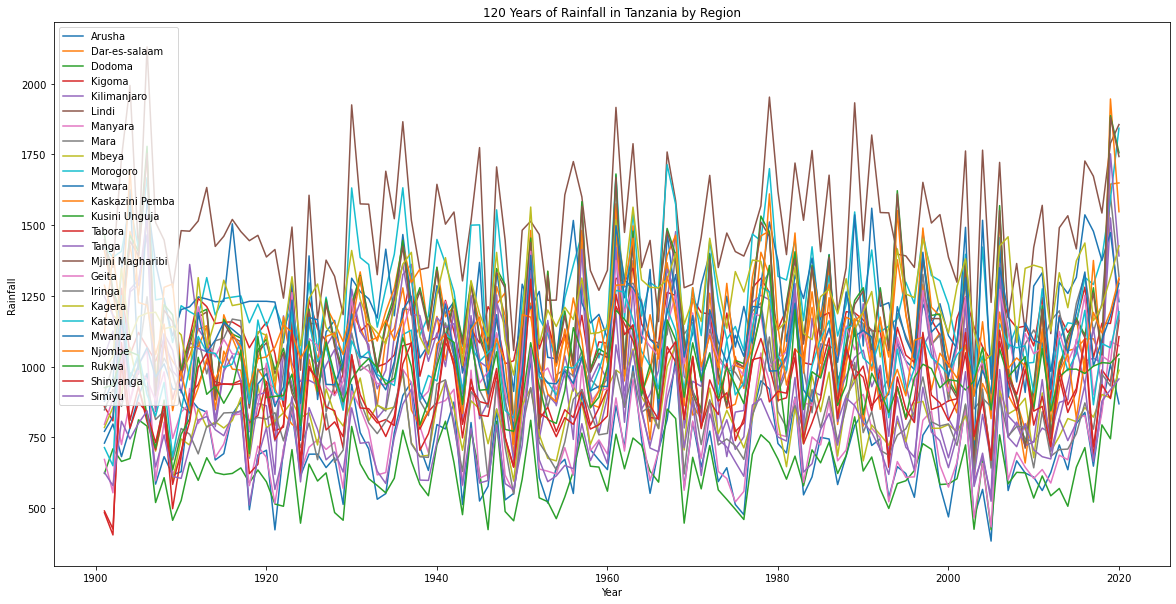

In [9]:
#Plotting last 120 years of precipitation by region in Tanzania:
plt.figure(figsize=(20,10))
plt.plot(pr_df['year'], pr_df['Arusha'], label='Arusha')
plt.plot(pr_df['year'], pr_df['Dar-es-salaam'], label='Dar-es-salaam')
plt.plot(pr_df['year'], pr_df['Dodoma'], label='Dodoma')
plt.plot(pr_df['year'], pr_df['Kigoma'], label='Kigoma')
plt.plot(pr_df['year'], pr_df['Kilimanjaro'], label='Kilimanjaro')
plt.plot(pr_df['year'], pr_df['Lindi'], label='Lindi')
plt.plot(pr_df['year'], pr_df['Manyara'], label='Manyara')
plt.plot(pr_df['year'], pr_df['Mara'], label='Mara')
plt.plot(pr_df['year'], pr_df['Mbeya'], label='Mbeya')
plt.plot(pr_df['year'], pr_df['Morogoro'], label='Morogoro')
plt.plot(pr_df['year'], pr_df['Mtwara'], label='Mtwara')
plt.plot(pr_df['year'], pr_df['Kaskazini Pemba'], label='Kaskazini Pemba')
plt.plot(pr_df['year'], pr_df['Kusini Unguja'], label='Kusini Unguja')
plt.plot(pr_df['year'], pr_df['Tabora'], label='Tabora')
plt.plot(pr_df['year'], pr_df['Tanga'], label='Tanga')
plt.plot(pr_df['year'], pr_df['Mjini Magharibi'], label='Mjini Magharibi')
plt.plot(pr_df['year'], pr_df['Geita'], label='Geita')
plt.plot(pr_df['year'], pr_df['Iringa'], label='Iringa')
plt.plot(pr_df['year'], pr_df['Kagera'], label='Kagera')
plt.plot(pr_df['year'], pr_df['Katavi'], label='Katavi')
plt.plot(pr_df['year'], pr_df['Mwanza'], label='Mwanza')
plt.plot(pr_df['year'], pr_df['Njombe'], label='Njombe')
plt.plot(pr_df['year'], pr_df['Rukwa'], label='Rukwa')
plt.plot(pr_df['year'], pr_df['Shinyanga'], label='Shinyanga')
plt.plot(pr_df['year'], pr_df['Simiyu'], label='Simiyu')
plt.title('120 Years of Rainfall in Tanzania by Region')
plt.ylabel('Rainfall')
plt.xlabel('Year')
plt.legend()
plt.show()

In [10]:
#Creating subset of data for only the last 20 years:
pr_df1 = pr_df[pr_df['year'] > 1999]

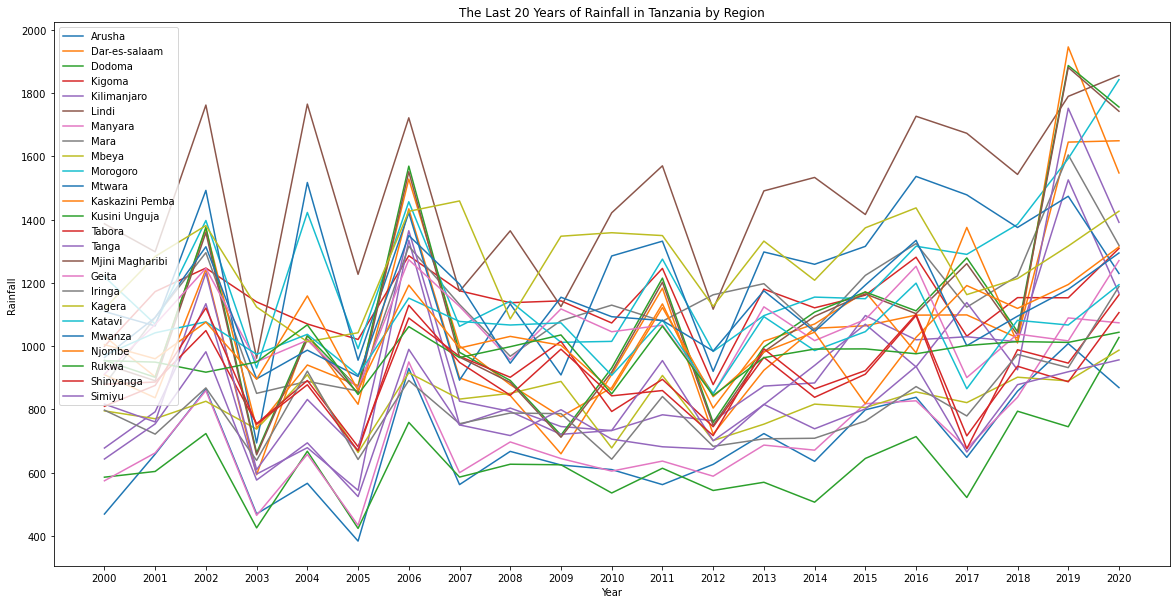

In [11]:
#Plotting last 20 years of precipitation by region in Tanzania:
plt.figure(figsize=(20,10))
plt.plot(pr_df1['year'], pr_df1['Arusha'], label='Arusha')
plt.plot(pr_df1['year'], pr_df1['Dar-es-salaam'], label='Dar-es-salaam')
plt.plot(pr_df1['year'], pr_df1['Dodoma'], label='Dodoma')
plt.plot(pr_df1['year'], pr_df1['Kigoma'], label='Kigoma')
plt.plot(pr_df1['year'], pr_df1['Kilimanjaro'], label='Kilimanjaro')
plt.plot(pr_df1['year'], pr_df1['Lindi'], label='Lindi')
plt.plot(pr_df1['year'], pr_df1['Manyara'], label='Manyara')
plt.plot(pr_df1['year'], pr_df1['Mara'], label='Mara')
plt.plot(pr_df1['year'], pr_df1['Mbeya'], label='Mbeya')
plt.plot(pr_df1['year'], pr_df1['Morogoro'], label='Morogoro')
plt.plot(pr_df1['year'], pr_df1['Mtwara'], label='Mtwara')
plt.plot(pr_df1['year'], pr_df1['Kaskazini Pemba'], label='Kaskazini Pemba')
plt.plot(pr_df1['year'], pr_df1['Kusini Unguja'], label='Kusini Unguja')
plt.plot(pr_df1['year'], pr_df1['Tabora'], label='Tabora')
plt.plot(pr_df1['year'], pr_df1['Tanga'], label='Tanga')
plt.plot(pr_df1['year'], pr_df1['Mjini Magharibi'], label='Mjini Magharibi')
plt.plot(pr_df1['year'], pr_df1['Geita'], label='Geita')
plt.plot(pr_df1['year'], pr_df1['Iringa'], label='Iringa')
plt.plot(pr_df1['year'], pr_df1['Kagera'], label='Kagera')
plt.plot(pr_df1['year'], pr_df1['Katavi'], label='Katavi')
plt.plot(pr_df1['year'], pr_df1['Mwanza'], label='Mwanza')
plt.plot(pr_df1['year'], pr_df1['Njombe'], label='Njombe')
plt.plot(pr_df1['year'], pr_df1['Rukwa'], label='Rukwa')
plt.plot(pr_df1['year'], pr_df1['Shinyanga'], label='Shinyanga')
plt.plot(pr_df1['year'], pr_df1['Simiyu'], label='Simiyu')
plt.title('The Last 20 Years of Rainfall in Tanzania by Region')
plt.ylabel('Rainfall')
plt.xticks(list(pr_df1['year']))
plt.xlabel('Year')
plt.legend()
plt.show()

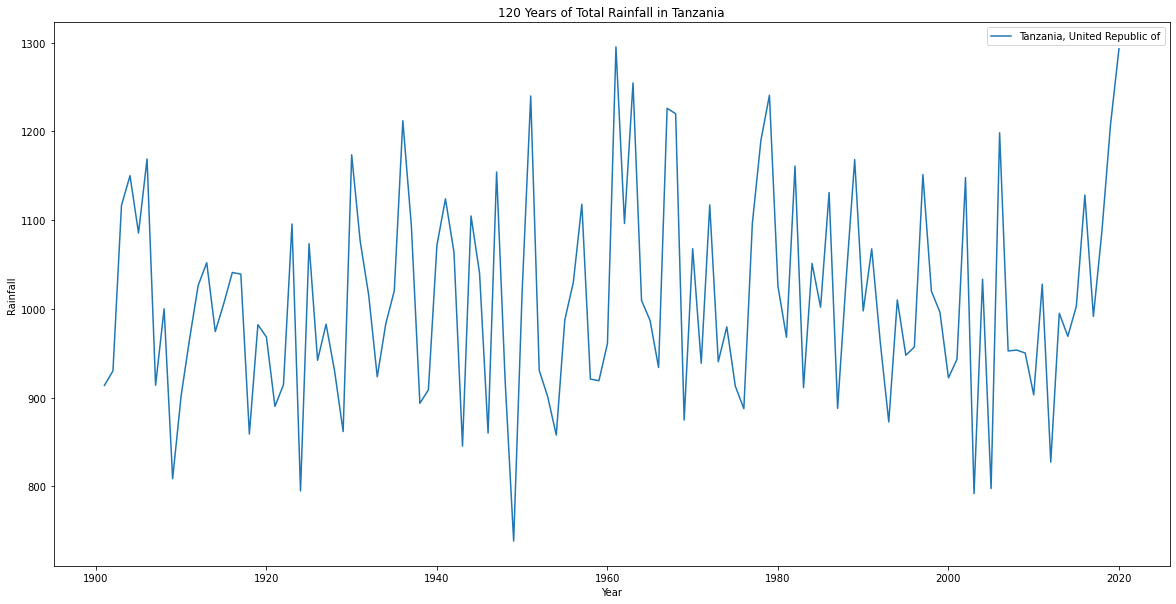

In [12]:
#Plotting last 120 years of precipitation in all of Tanzania:
plt.figure(figsize=(20,10))
plt.plot(pr_df['year'], pr_df['Tanzania, United Republic of'], label='Tanzania, United Republic of')
plt.title('120 Years of Total Rainfall in Tanzania')
plt.ylabel('Rainfall')
plt.xlabel('Year')
plt.legend()
plt.show()

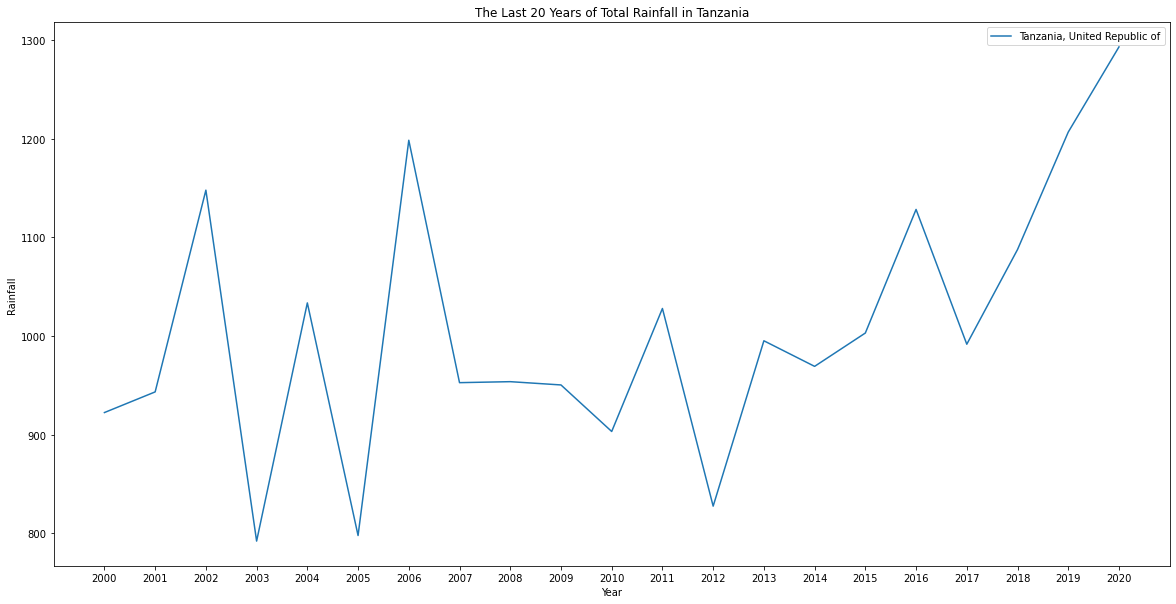

In [13]:
#Plotting last 20 years of precipitation in all of Tanzania:
plt.figure(figsize=(20,10))
plt.plot(pr_df1['year'], pr_df1['Tanzania, United Republic of'], label='Tanzania, United Republic of')
plt.title('The Last 20 Years of Total Rainfall in Tanzania')
plt.ylabel('Rainfall')
plt.xlabel('Year')
plt.xticks(list(pr_df1['year']))
plt.legend()
plt.show()

In [14]:
#Creating new df with 5 year averages for last two years:
avg_pr_df = pr_df1.T
avg_pr_df['avg_2005']= (avg_pr_df[2001] + avg_pr_df[2002] + avg_pr_df[2003] + avg_pr_df[2004] + avg_pr_df[2005])/5
avg_pr_df['avg_2010']= (avg_pr_df[2006] + avg_pr_df[2007] + avg_pr_df[2008] + avg_pr_df[2009] + avg_pr_df[2010])/5
avg_pr_df['avg_2015']= (avg_pr_df[2011] + avg_pr_df[2012] + avg_pr_df[2013] + avg_pr_df[2014] + avg_pr_df[2015])/5
avg_pr_df['avg_2020']= (avg_pr_df[2016] + avg_pr_df[2017] + avg_pr_df[2018] + avg_pr_df[2019] + avg_pr_df[2020])/5
avg_pr_df = avg_pr_df.drop(columns=([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]))
avg_pr_df = avg_pr_df.T
avg_pr_df['year'] = [2000, 2005,2010, 2015, 2020]

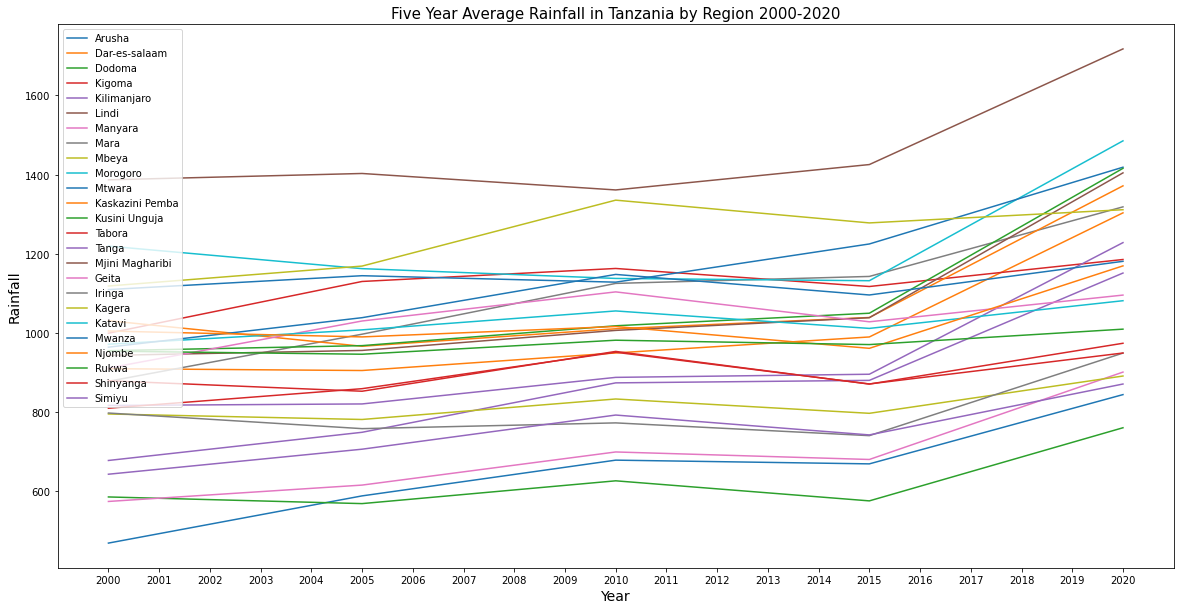

In [15]:
#Plotting precipitation by region for the past 20 years as 5 year averages:
avg_pr_df.T
plt.figure(figsize=(20,10))
plt.plot(avg_pr_df['year'], avg_pr_df['Arusha'], label='Arusha')
plt.plot(avg_pr_df['year'], avg_pr_df['Dar-es-salaam'], label='Dar-es-salaam')
plt.plot(avg_pr_df['year'], avg_pr_df['Dodoma'], label='Dodoma')
plt.plot(avg_pr_df['year'], avg_pr_df['Kigoma'], label='Kigoma')
plt.plot(avg_pr_df['year'], avg_pr_df['Kilimanjaro'], label='Kilimanjaro')
plt.plot(avg_pr_df['year'], avg_pr_df['Lindi'], label='Lindi')
plt.plot(avg_pr_df['year'], avg_pr_df['Manyara'], label='Manyara')
plt.plot(avg_pr_df['year'], avg_pr_df['Mara'], label='Mara')
plt.plot(avg_pr_df['year'], avg_pr_df['Mbeya'], label='Mbeya')
plt.plot(avg_pr_df['year'], avg_pr_df['Morogoro'], label='Morogoro')
plt.plot(avg_pr_df['year'], avg_pr_df['Mtwara'], label='Mtwara')
plt.plot(avg_pr_df['year'], avg_pr_df['Kaskazini Pemba'], label='Kaskazini Pemba')
plt.plot(avg_pr_df['year'], avg_pr_df['Kusini Unguja'], label='Kusini Unguja')
plt.plot(avg_pr_df['year'], avg_pr_df['Tabora'], label='Tabora')
plt.plot(avg_pr_df['year'], avg_pr_df['Tanga'], label='Tanga')
plt.plot(avg_pr_df['year'], avg_pr_df['Mjini Magharibi'], label='Mjini Magharibi')
plt.plot(avg_pr_df['year'], avg_pr_df['Geita'], label='Geita')
plt.plot(avg_pr_df['year'], avg_pr_df['Iringa'], label='Iringa')
plt.plot(avg_pr_df['year'], avg_pr_df['Kagera'], label='Kagera')
plt.plot(avg_pr_df['year'], avg_pr_df['Katavi'], label='Katavi')
plt.plot(avg_pr_df['year'], avg_pr_df['Mwanza'], label='Mwanza')
plt.plot(avg_pr_df['year'], avg_pr_df['Njombe'], label='Njombe')
plt.plot(avg_pr_df['year'], avg_pr_df['Rukwa'], label='Rukwa')
plt.plot(avg_pr_df['year'], avg_pr_df['Shinyanga'], label='Shinyanga')
plt.plot(avg_pr_df['year'], avg_pr_df['Simiyu'], label='Simiyu')
plt.title('Five Year Average Rainfall in Tanzania by Region 2000-2020', fontsize=15)
plt.ylabel('Rainfall', fontsize=14)
plt.xticks(list(pr_df1['year']))
plt.xlabel('Year', fontsize=14)
plt.legend()
plt.show()

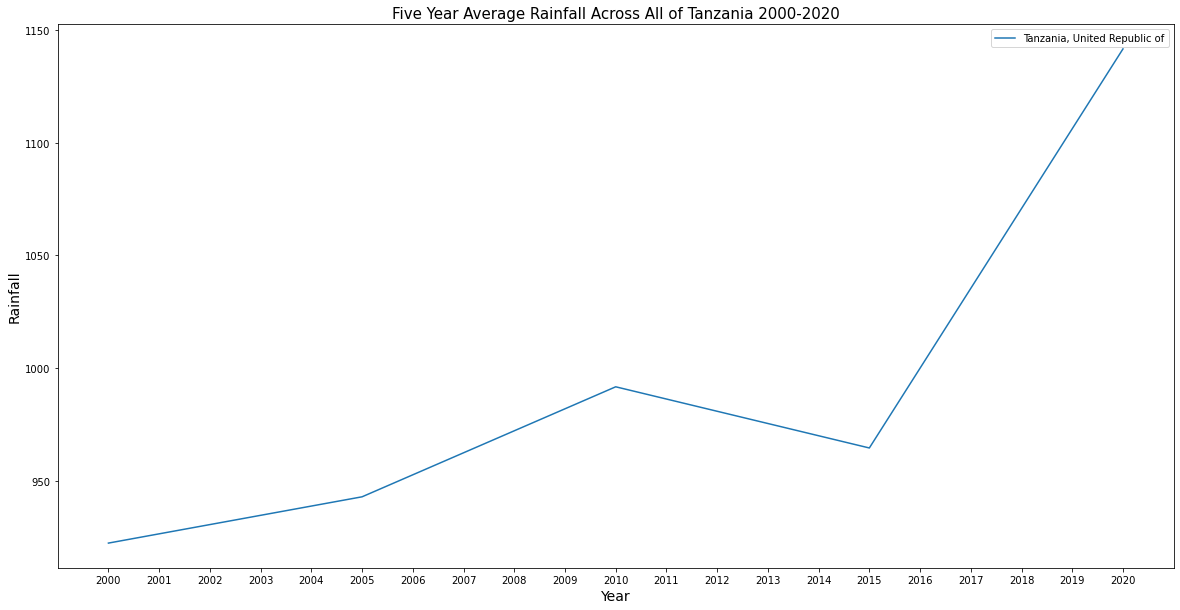

In [16]:
#Plotting precipitation for all of Tanzania for the past 20 years as 5 year averages:
plt.figure(figsize=(20,10))
plt.plot(avg_pr_df['year'], avg_pr_df['Tanzania, United Republic of'], label='Tanzania, United Republic of')
plt.title('Five Year Average Rainfall Across All of Tanzania 2000-2020', fontsize=15)
plt.ylabel('Rainfall', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(list(pr_df1['year']))
plt.legend()
plt.show()

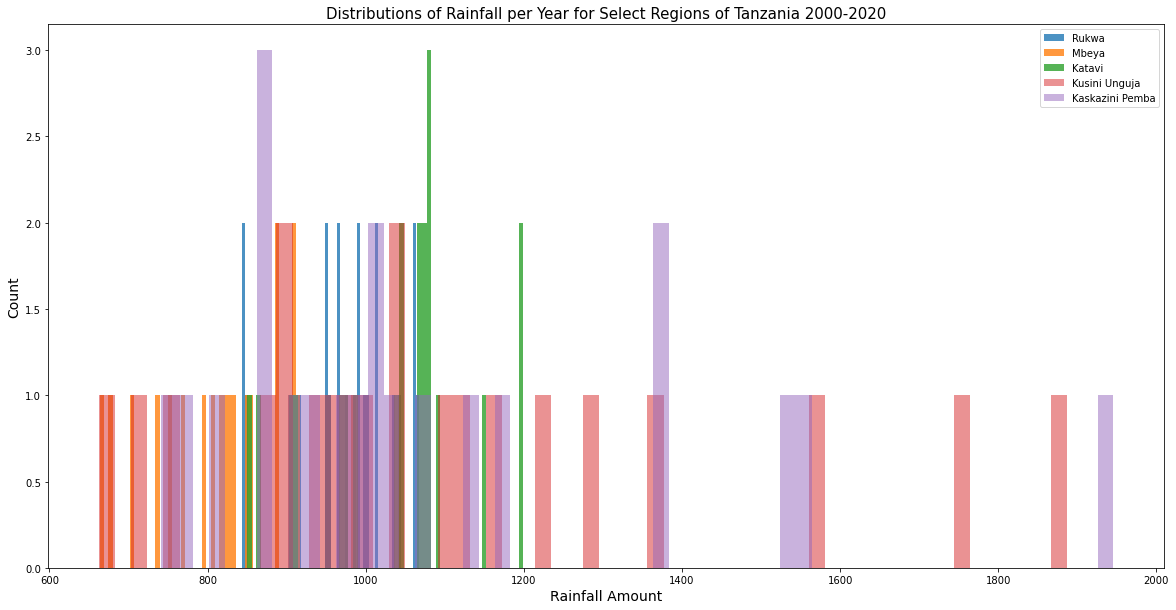

In [17]:
#Overlapping histograms of rainfall distribution for regions with largest and smallest ranges:
plt.figure(figsize=(20,10))
plt.hist(pr_df1['Rukwa'], bins=60, alpha=.8, label='Rukwa');
plt.hist(pr_df1['Mbeya'], bins=60, alpha=.8, label='Mbeya');
plt.hist(pr_df1['Katavi'], bins=60, alpha=.8, label='Katavi');
plt.hist(pr_df1['Kusini Unguja'], bins=60, alpha=.5, label='Kusini Unguja');
plt.hist(pr_df1['Kaskazini Pemba'], bins=60, alpha=.5, label='Kaskazini Pemba');
plt.title('Distributions of Rainfall per Year for Select Regions of Tanzania 2000-2020', fontsize=15)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Rainfall Amount', fontsize=14)
plt.legend();

In [20]:
#Creating new df with:
#--Average rainfall by region...
#--Range of rainfall by region...
#--Range of upper and lower quartiles average rainfall by region...
#--Range of upper and lower halves average rainfall by region...
reg_range = pd.DataFrame()
reg_range['range'] = [pr_df1[i].max() - pr_df1[i].min() for i in list(pr_df1.drop(columns=('year')).columns)]
reg_range['avg_range_by_quartiles'] = [pr_df1[i].sort_values(ascending=False)[:5].mean() - pr_df1[i].sort_values()[:5].mean() for i in list(pr_df1.drop(columns=('year')).columns)]
reg_range['avg_range_by_halves'] = [pr_df1[i].sort_values(ascending=False)[:10].mean() - pr_df1[i].sort_values()[:10].mean() for i in list(pr_df1.drop(columns=('year')).columns)]
reg_range['avg'] = [pr_df1[i].mean() for i in list(pr_df1.drop(columns=('year')).columns)]
reg_range.index = list(pr_df1.drop(columns=('year')).columns)
reg_range.sort_values('range')

,range,avg_range_by_quartiles,avg_range_by_halves,avg
Rukwa,223.25,172.816,107.468,975.929524
Mbeya,323.52,217.346,139.392,824.294286
Katavi,348.96,243.490,150.886,1035.831429
Geita,424.39,337.744,210.223,1057.115714
Kigoma,430.39,273.504,159.485,1141.760000
Kagera,444.78,348.970,251.212,1265.935714
Mwanza,452.76,358.538,238.310,1108.540952
Shinyanga,460.20,356.416,217.952,903.088095
Simiyu,465.24,339.926,221.007,771.733333
Singida,477.47,270.656,165.109,654.840000


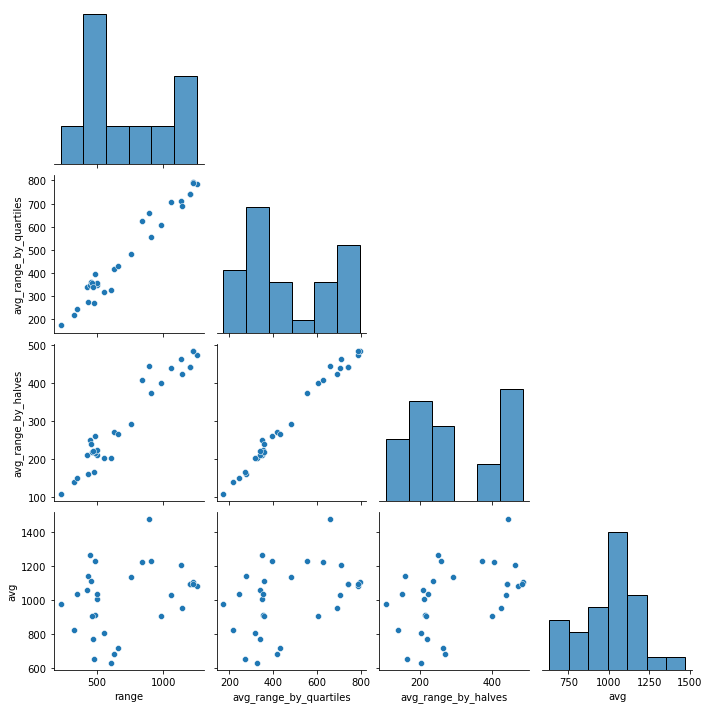

In [134]:
#Pairplotting correlation between the variables confirming strong correlation between precipitation ranges at all scales:
sns.pairplot(reg_range, corner=True);

<br>
<br>
<br>

## UNICEF Utility Dataset:

In [5]:
#Reading in UNICEF Utility Dataset:
uni_df = pd.read_csv('./data/washdash-download (1).csv')
# uni_df = pr_df.set_index('Unnamed: 0')
# pr_df['year'] = pr_df.index

In [6]:
#EDA for counts of different services in dataset:
uni_df['Service Type'].value_counts()

Drinking water    676
Sanitation        676
Hygiene            90
Name: Service Type, dtype: int64

In [7]:
#EDA for counts of different service levels in dataset:
uni_df['Service level'].value_counts()

Limited service            368
At least basic             338
Unimproved                 338
Open defecation            169
Surface water              169
Basic service               30
No handwashing facility     30
Name: Service level, dtype: int64

In [8]:
#EDA for counts of different service levels within service type of 'Drinking water' in dataset:
uni_df[uni_df['Service Type']== 'Drinking water']['Service level'].value_counts()

At least basic     169
Unimproved         169
Limited service    169
Surface water      169
Name: Service level, dtype: int64

In [9]:
#EDA for counts of different service levels within service type of 'Sanitation' in dataset:
uni_df[uni_df['Service Type']== 'Sanitation']['Service level'].value_counts()

Unimproved         169
Open defecation    169
Limited service    169
At least basic     169
Name: Service level, dtype: int64

In [10]:
#EDA for counts of different service levels within service type of 'Hygiene' in dataset:
uni_df[uni_df['Service Type']== 'Hygiene']['Service level'].value_counts()

Limited service            30
Basic service              30
No handwashing facility    30
Name: Service level, dtype: int64

In [11]:
#Looking for nulls. No nulls:
uni_df.isnull().sum()

ISO3             0
Country          0
Region           0
Service Type     0
Year             0
Coverage         0
Service level    0
dtype: int64

In [15]:
#Looking for counts of rows by year:
#2005-2010 have uniform value counts...
#2012-2010 have non-uniform value counts...
uni_df['Year'].value_counts()

2016    330
2017    248
2012    240
2005    208
2008    208
2010    208
Name: Year, dtype: int64

In [13]:
#Creating new dataframes of only water utility data and sanitation utility data:
uni_df_water = uni_df[uni_df['Service Type'] == 'Drinking water']
uni_df_water = uni_df_water.drop(columns=(['ISO3','Country']))
uni_df_sanitation = uni_df[uni_df['Service Type'] == 'Sanitation'] 
uni_df_sanitation = uni_df_sanitation.drop(columns=(['ISO3','Country']))

In [14]:
#Looking for counts of rows by year within new water dataframe:
#Some years have more values than others.
uni_df_water['Year'].value_counts()

2017    124
2012    120
2016    120
2005    104
2008    104
2010    104
Name: Year, dtype: int64

In [13]:
#Looking for counts of rows by service level within new water dataframe:
#Values for different service levels are uniform...
uni_df_water['Service level'].value_counts()

At least basic     169
Unimproved         169
Limited service    169
Surface water      169
Name: Service level, dtype: int64

In [18]:
#Looking for counts of rows by year within new sanitation dataframe:
#Some years have more values than others.
uni_df_sanitation['Year'].value_counts()

2017    124
2012    120
2016    120
2005    104
2008    104
2010    104
Name: Year, dtype: int64

In [14]:
#Looking for counts of rows by service level within new sanitation dataframe:
#Values for different service levels are uniform...
uni_df_sanitation['Service level'].value_counts()

Unimproved         169
Open defecation    169
Limited service    169
At least basic     169
Name: Service level, dtype: int64

In [44]:
#Regions included in data collected from 2005-2010:
#Uniquely includes "Town West", "Zanziba South", "Zanzibar North", "Pemba North", and "Pemba South"...
uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2005)]['Region']

0              Arusha
15       Dar Es Salam
18             Dodoma
24             Iringa
37             Kagera
44             Kigoma
52        Kilimanjaro
63              Lindi
69            Manyara
79               Mara
81              Mbeya
92           Morogoro
100            Mtwara
108            Mwanza
114       Pemba North
124       Pemba South
133             Pwani
139             Rukwa
151            Ruvuma
156         Shinyanga
161           Singida
174            Tabora
180             Tanga
188         Town West
192     Zanziba South
202    Zanzibar North
Name: Region, dtype: object

In [43]:
#Regions included in data collected from 2012-2016:
#Uniquely includes "Kusini Pemba","Kusini Unguja","Kaskazini Pemba"...
#..."Kaskazini Unguja","Mjini Magharibi","Simiyu", and "Katavi"...
uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2016)]['Region']
#len(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2010)]['Coverage'])


873               Arusha
877        Dar Es Salaam
893               Dodoma
901                Geita
913               Iringa
922               Kagera
937      Kaskazini Pemba
947     Kaskazini Unguja
959               Katavi
963               Kigoma
975          Kilimanjaro
991         Kusini Pemba
996        Kusini Unguja
1016               Lindi
1025             Manyara
1037                Mara
1045               Mbeya
1055     Mjini Magharibi
1068            Morogoro
1082              Mtwara
1087              Mwanza
1104              Njombe
1108               Pwani
1118               Rukwa
1128              Ruvuma
1140           Shinyanga
1153              Simiyu
1171             Singida
1175              Tabora
1184               Tanga
Name: Region, dtype: object

In [46]:
#Regions included in data collected from 2017:
#Uniquely includes "Songwe":
uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2017)]['Region']

1200              Arusha
1202       Dar Es Salaam
1215              Dodoma
1219               Geita
1228              Iringa
1238              Kagera
1247     Kaskazini Pemba
1253    Kaskazini Unguja
1264              Katavi
1269              Kigoma
1278         Kilimanjaro
1288        Kusini Pemba
1290       Kusini Unguja
1302               Lindi
1310             Manyara
1315                Mara
1329               Mbeya
1336     Mjini Magharibi
1343            Morogoro
1352              Mtwara
1355              Mwanza
1368              Njombe
1371               Pwani
1379               Rukwa
1389              Ruvuma
1395           Shinyanga
1407              Simiyu
1415             Singida
1421              Songwe
1428              Tabora
1435               Tanga
Name: Region, dtype: object

In [77]:
#Removing regions not included in water point dataset from water utility dataframe:
#Fixing four instances of Dar Es Salam to Dar Es Salaam...
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Songwe')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Simiyu')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Geita')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Njombe')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Mjini Magharibi')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Katavi')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kaskazini')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kusini Pemba')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kaskazini Pemba')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kaskazini Unguja')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kusini Unguja')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Zanzibar North')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Town West')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Pemba South')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Pemba North')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Unguja 2')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Unguja 3')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Zanzibar South')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Unguja 1')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Pemba 2')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Kusini')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Zanziba South')])
uni_df_water = uni_df_water.drop(uni_df_water.index[(uni_df_water['Region'] == 'Pemba 1')])
uni_df_water["Region"].replace({"Dar Es Salam": "Dar Es Salaam"}, inplace=True)
uni_df_water['Region'].value_counts()

Arusha           24
Morogoro         24
Tabora           24
Singida          24
Shinyanga        24
Ruvuma           24
Rukwa            24
Pwani            24
Mwanza           24
Mtwara           24
Mbeya            24
Dar Es Salaam    24
Mara             24
Manyara          24
Lindi            24
Kilimanjaro      24
Kigoma           24
Kagera           24
Iringa           24
Dodoma           24
Tanga            24
Name: Region, dtype: int64

In [82]:
#Creating new dataframe of Water utility quality percentages by region from year to year:
new_uni_df_water_pre = pd.DataFrame()
new_uni_df_water_pre['Region'] = uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2005)]['Region']
new_uni_df_water_pre['water_basic_2005'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2005)]['Coverage'])
new_uni_df_water_pre['water_basic_2008'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2008)]['Coverage'])
new_uni_df_water_pre['water_basic_2010'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2010)]['Coverage'])
new_uni_df_water_pre['water_basic_2012'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2012)]['Coverage'])
new_uni_df_water_pre['water_basic_2016'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2016)]['Coverage'])
new_uni_df_water_pre['water_basic_2017'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'At least basic') &  (uni_df_water['Year'] == 2017)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2005'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2005)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2008'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2008)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2010'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2010)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2012'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2012)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2016'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2016)]['Coverage'])
new_uni_df_water_pre['water_unimproved_2017'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Unimproved') &  (uni_df_water['Year'] == 2017)]['Coverage'])
new_uni_df_water_pre['water_limited_2005'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2005)]['Coverage'])
new_uni_df_water_pre['water_limited_2008'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2008)]['Coverage'])
new_uni_df_water_pre['water_limited_2010'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2010)]['Coverage'])
new_uni_df_water_pre['water_limited_2012'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2012)]['Coverage'])
new_uni_df_water_pre['water_limited_2016'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2016)]['Coverage'])
new_uni_df_water_pre['water_limited_2017'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Limited service') &  (uni_df_water['Year'] == 2017)]['Coverage'])
new_uni_df_water_pre['water_surface_2005'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2005)]['Coverage'])
new_uni_df_water_pre['water_surface_2008'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2008)]['Coverage'])
new_uni_df_water_pre['water_surface_2010'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2010)]['Coverage'])
new_uni_df_water_pre['water_surface_2012'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2012)]['Coverage'])
new_uni_df_water_pre['water_surface_2016'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2016)]['Coverage'])
new_uni_df_water_pre['water_surface_2017'] = list(uni_df_water.loc[(uni_df_water['Service level'] == 'Surface water') &  (uni_df_water['Year'] == 2017)]['Coverage'])
new_uni_df_water_pre


,Region,water_basic_2005,water_basic_2008,water_basic_2010,water_basic_2012,water_basic_2016,water_basic_2017,water_unimproved_2005,water_unimproved_2008,water_unimproved_2010,...,water_limited_2010,water_limited_2012,water_limited_2016,water_limited_2017,water_surface_2005,water_surface_2008,water_surface_2010,water_surface_2012,water_surface_2016,water_surface_2017
0,Arusha,44.77583,46.85551,61.37929,54.65171,58.28709,73.92895,14.42420,7.10011,9.32201,...,16.16676,14.61535,22.85539,14.74645,18.07185,16.54550,13.13193,12.23291,11.43127,6.56372
15,Dar Es Salaam,89.88359,86.17239,88.35046,94.52692,89.92259,93.01502,7.30727,10.33435,5.98656,...,5.66297,1.05136,8.01122,1.16118,0.16518,0.03387,0.00000,0.00000,0.00000,0.00000
18,Dodoma,53.39603,29.19334,15.79254,27.33214,47.78264,46.00347,13.38491,29.29445,38.58250,...,24.60595,19.07217,18.20731,21.72459,11.39342,20.27097,21.01901,4.79744,0.29996,9.55407
24,Iringa,38.37422,63.29417,36.96397,22.65630,55.36443,66.52240,29.63886,10.99518,31.70032,...,5.39078,1.16736,3.62100,4.23282,17.45441,19.64523,25.94493,32.86971,14.61804,13.04358
37,Kagera,28.48370,30.48809,30.97666,29.49304,27.84752,29.96989,16.95867,22.29905,30.38604,...,6.63467,15.39743,16.54866,15.59417,41.74589,30.54517,32.00263,36.78759,25.36992,13.91018
44,Kigoma,35.15166,40.38978,30.31541,61.85246,41.61460,58.17626,21.22835,14.27281,26.77693,...,12.72294,15.55988,18.16246,3.65273,30.79139,28.15085,30.18472,12.59565,5.53877,19.70613
52,Kilimanjaro,67.65575,78.00624,63.04528,80.71656,85.98049,90.87798,8.86138,3.59649,13.28140,...,11.18924,7.40196,10.13756,1.53688,14.80378,9.79001,12.48408,3.48921,1.06125,1.75240
63,Lindi,25.79108,34.67709,19.93003,29.48056,40.44351,38.08021,54.80893,42.60802,59.18517,...,5.66416,15.73502,10.37919,4.14503,4.74401,14.81824,15.22064,21.83691,14.89809,7.46318
69,Manyara,23.91870,35.63526,32.96417,33.04035,44.72969,45.53574,44.15756,18.34437,12.80200,...,15.97959,14.22768,12.29297,6.09926,5.84880,28.04325,38.25424,38.27676,22.60786,13.56492
79,Mara,20.96128,33.13354,29.77521,24.30006,32.45572,35.97252,32.92985,29.75268,38.29323,...,6.94354,10.46398,11.21556,14.47204,42.98146,30.13192,24.98802,20.71641,24.78402,8.24948


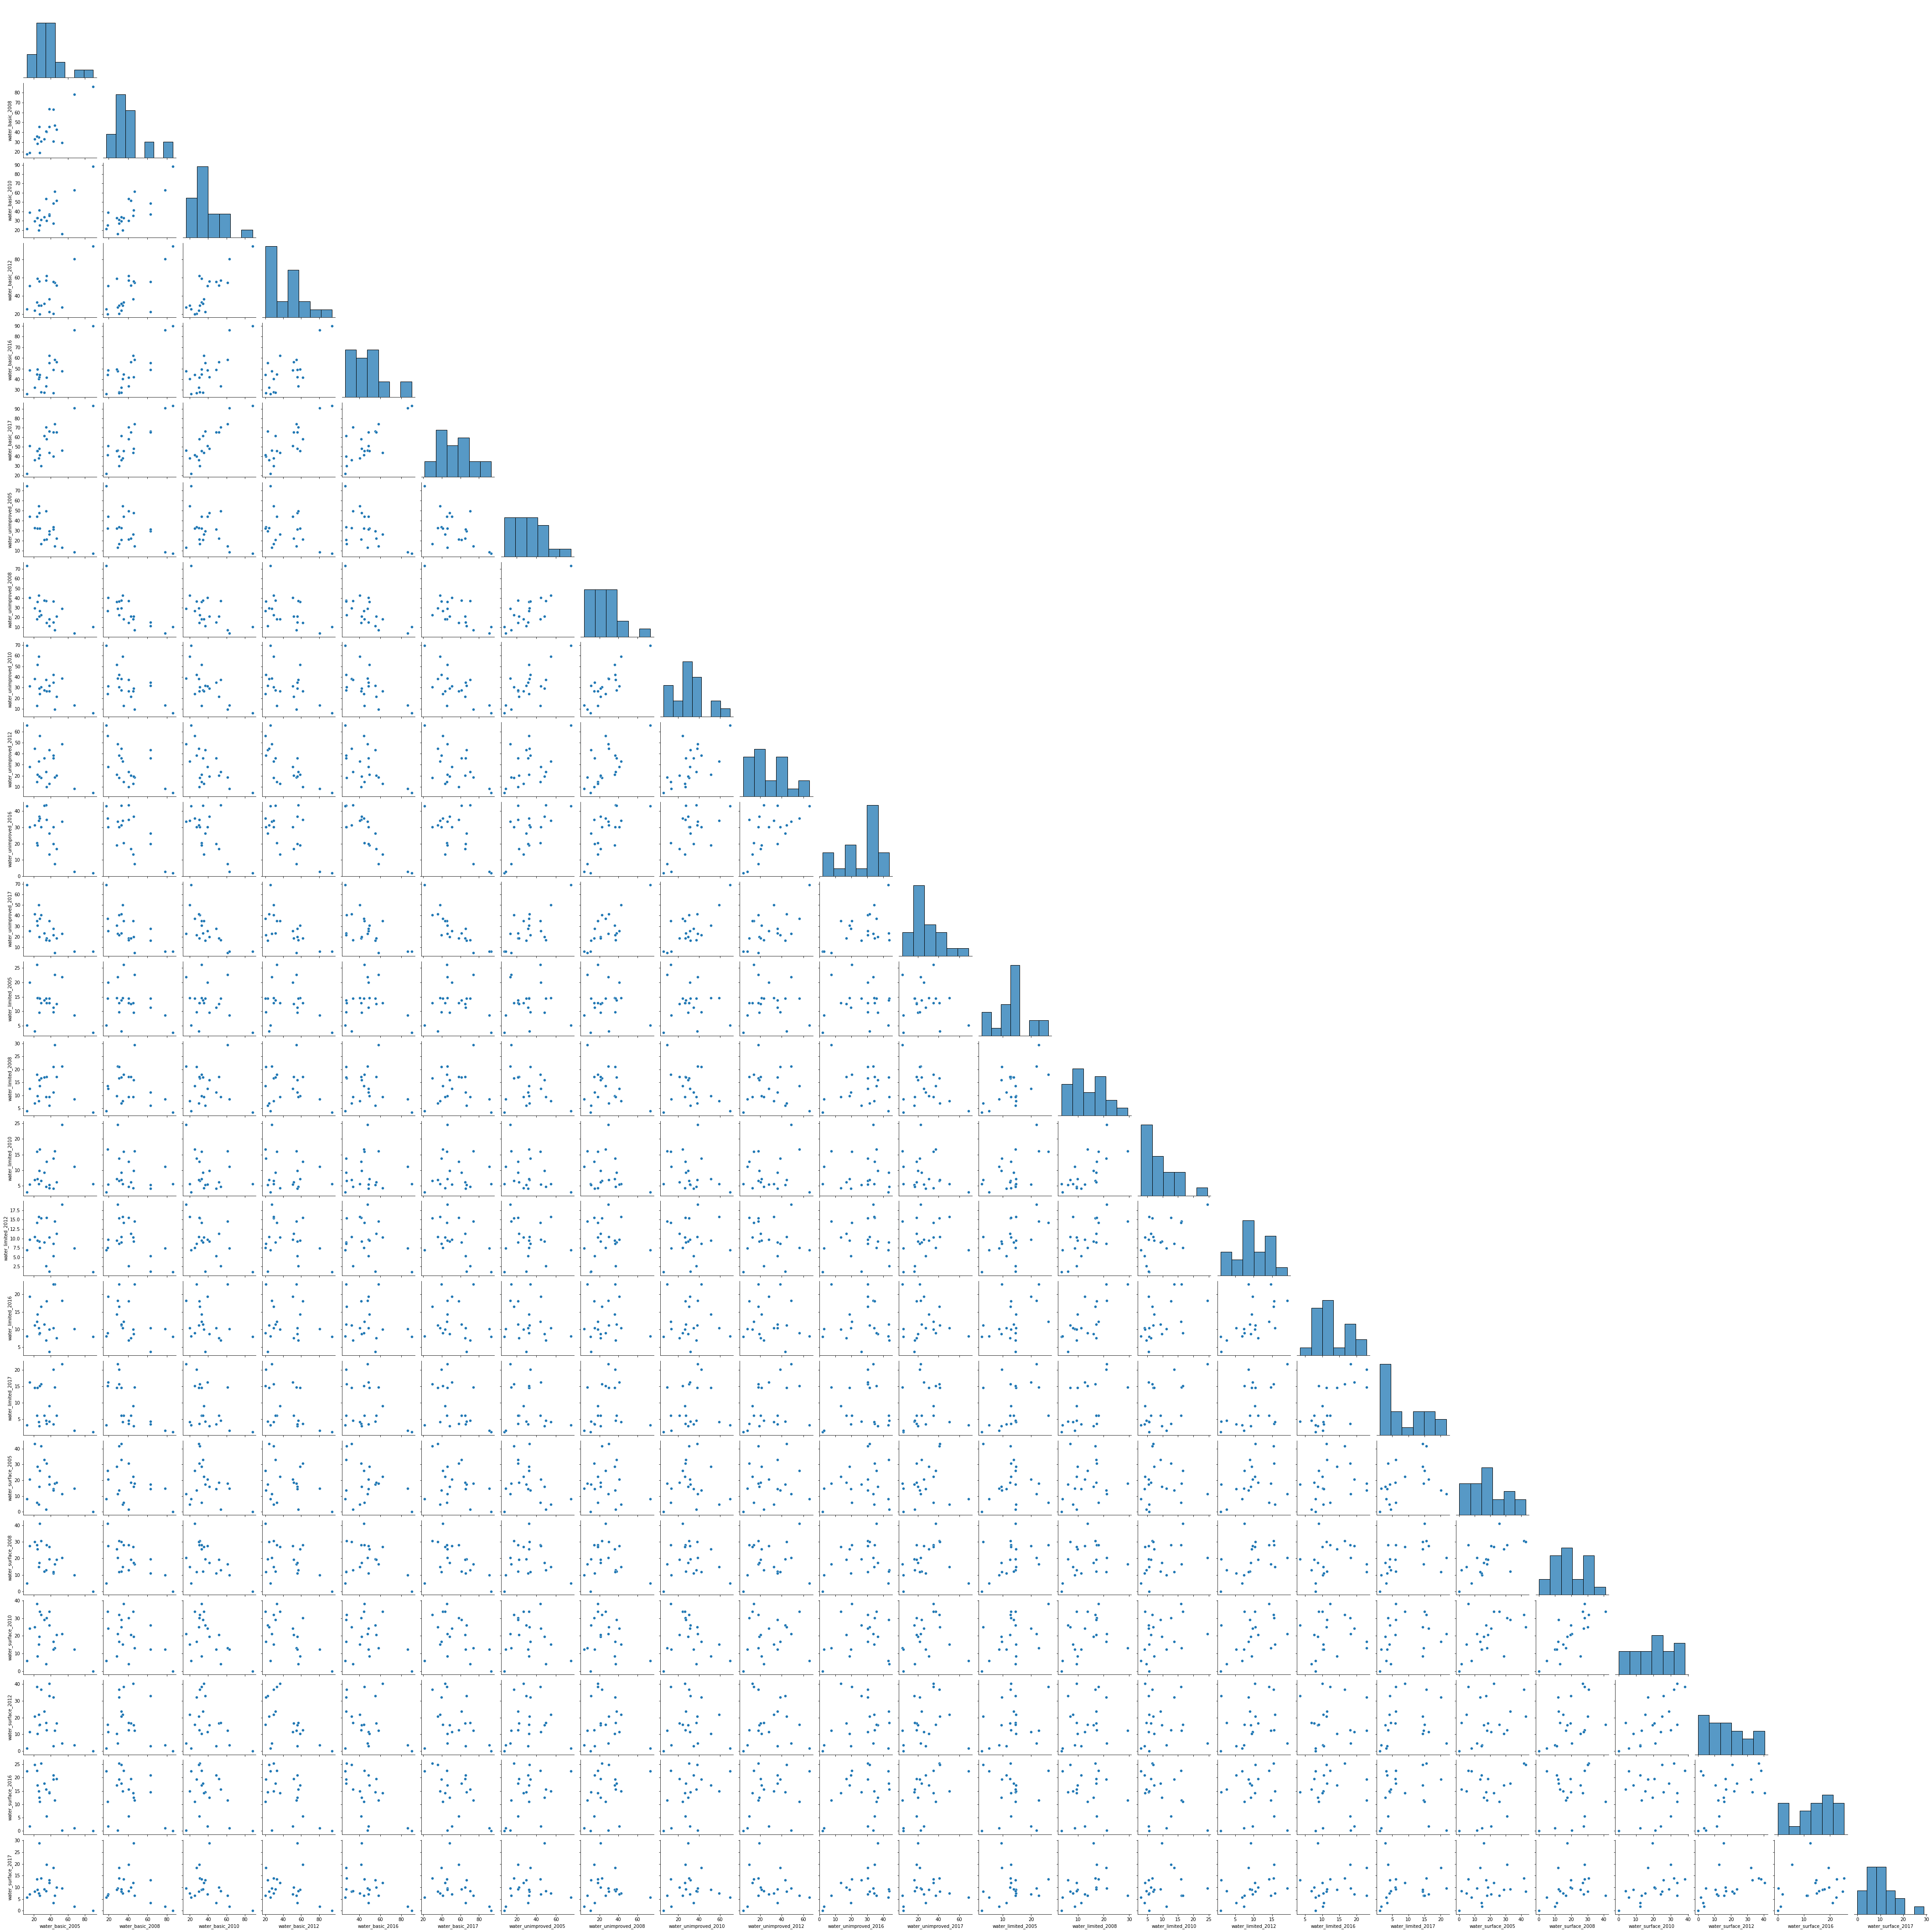

In [93]:
sns.pairplot(new_uni_df_water_pre, corner=True);

In [87]:
#Removing regions not included in water point dataset from sanitation utility dataframe:
#Fixing four instances of Dar Es Salam to Dar Es Salaam...
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Songwe')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Simiyu')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Geita')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Njombe')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Mjini Magharibi')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Katavi')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kaskazini')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kusini Pemba')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kaskazini Pemba')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kaskazini Unguja')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kusini Unguja')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Zanzibar North')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Town West')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Pemba South')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Pemba North')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Unguja 2')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Unguja 3')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Zanzibar South')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Unguja 1')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Pemba 2')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Kusini')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Zanziba South')])
uni_df_sanitation = uni_df_sanitation.drop(uni_df_sanitation.index[(uni_df_sanitation['Region'] == 'Pemba 1')])
uni_df_sanitation["Region"].replace({"Dar Es Salam": "Dar Es Salaam"}, inplace=True)
uni_df_sanitation['Region'].value_counts()

Arusha           24
Morogoro         24
Tabora           24
Singida          24
Shinyanga        24
Ruvuma           24
Rukwa            24
Pwani            24
Mwanza           24
Mtwara           24
Mbeya            24
Dar Es Salaam    24
Mara             24
Manyara          24
Lindi            24
Kilimanjaro      24
Kigoma           24
Kagera           24
Iringa           24
Dodoma           24
Tanga            24
Name: Region, dtype: int64

In [90]:
#Creating new dataframe of Sanitation utility quality percentages by region from year to year:
new_uni_df_sanitation_pre = pd.DataFrame()
new_uni_df_sanitation_pre['Region'] = uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2005)]['Region']
new_uni_df_sanitation_pre['sanitation_basic_2005'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2005)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_basic_2008'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2008)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_basic_2010'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2010)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_basic_2012'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2012)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_basic_2016'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2016)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_basic_2017'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'At least basic') &  (uni_df_sanitation['Year'] == 2017)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2005'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2005)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2008'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2008)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2010'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2010)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2012'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2012)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2016'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2016)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_unimproved_2017'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Unimproved') &  (uni_df_sanitation['Year'] == 2017)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2005'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2005)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2008'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2008)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2010'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2010)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2012'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2012)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2016'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2016)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_limited_2017'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Limited service') &  (uni_df_sanitation['Year'] == 2017)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2005'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2005)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2008'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2008)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2010'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2010)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2012'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2012)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2016'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2016)]['Coverage'])
new_uni_df_sanitation_pre['sanitation_opendef_2017'] = list(uni_df_sanitation.loc[(uni_df_sanitation['Service level'] == 'Open defecation') &  (uni_df_sanitation['Year'] == 2017)]['Coverage'])
new_uni_df_sanitation_pre

,Region,sanitation_basic_2005,sanitation_basic_2008,sanitation_basic_2010,sanitation_basic_2012,sanitation_basic_2016,sanitation_basic_2017,sanitation_unimproved_2005,sanitation_unimproved_2008,sanitation_unimproved_2010,...,sanitation_limited_2010,sanitation_limited_2012,sanitation_limited_2016,sanitation_limited_2017,sanitation_opendef_2005,sanitation_opendef_2008,sanitation_opendef_2010,sanitation_opendef_2012,sanitation_opendef_2016,sanitation_opendef_2017
7,Arusha,8.89419,8.15326,8.20415,12.36102,25.25220,55.42895,53.97192,47.73611,52.29515,...,8.63041,7.49078,18.35768,23.92370,27.77759,35.53375,30.87029,29.19030,19.26900,11.71480
9,Dar Es Salaam,18.15037,22.17716,24.83101,36.41636,54.72797,43.43455,68.77048,61.99941,56.90884,...,17.67950,40.25087,39.11605,50.72939,0.15622,0.03345,0.58065,0.36221,0.02435,0.06616
20,Dodoma,5.49051,6.00097,5.23471,15.97591,10.90026,16.29770,81.66229,71.68034,73.54771,...,1.77990,18.07448,5.95140,2.87941,10.98033,20.27825,19.43768,19.55768,6.88917,4.00190
30,Iringa,24.79864,25.64703,30.54323,26.89619,20.01617,39.48259,66.31094,64.97687,63.11439,...,5.05787,3.63771,17.45834,16.48218,4.78384,5.12901,1.28451,0.00407,1.52949,1.04390
34,Kagera,3.97841,5.93431,7.91508,15.61137,8.77660,24.23968,84.09358,76.80486,78.17832,...,1.57478,3.57445,4.47440,15.23150,11.13646,16.08014,12.33182,7.43330,1.96823,2.23443
40,Kigoma,7.95048,8.29024,10.93034,19.41403,12.04159,34.36682,79.68843,77.74359,80.17900,...,6.21314,9.14490,3.78111,17.49807,7.84179,9.25373,2.67752,5.76185,9.58617,3.22725
51,Kilimanjaro,14.34493,14.53908,15.98993,56.36245,49.25062,67.50517,78.01438,77.45214,75.64407,...,7.46611,12.44188,13.03514,9.30129,0.94267,1.22011,0.89989,0.62874,2.47374,0.63983
58,Lindi,30.33396,26.28608,26.77994,25.93847,8.17865,47.92604,55.90402,50.25972,56.55211,...,6.10867,4.20219,4.11546,20.14632,6.84266,17.45817,10.55927,12.29840,3.49372,2.87437
65,Manyara,4.11644,7.30548,7.25644,4.60470,10.47921,40.96797,77.54433,66.75131,64.15645,...,0.84848,1.65147,3.04418,17.33506,17.85790,25.08899,27.73863,23.13686,24.32159,8.19356
77,Mara,2.69470,8.04218,7.66587,14.28488,15.17023,39.16550,54.57723,56.03261,50.04399,...,4.01491,12.90005,9.67339,27.02206,41.31676,31.71321,38.27524,37.58569,28.43281,19.33737


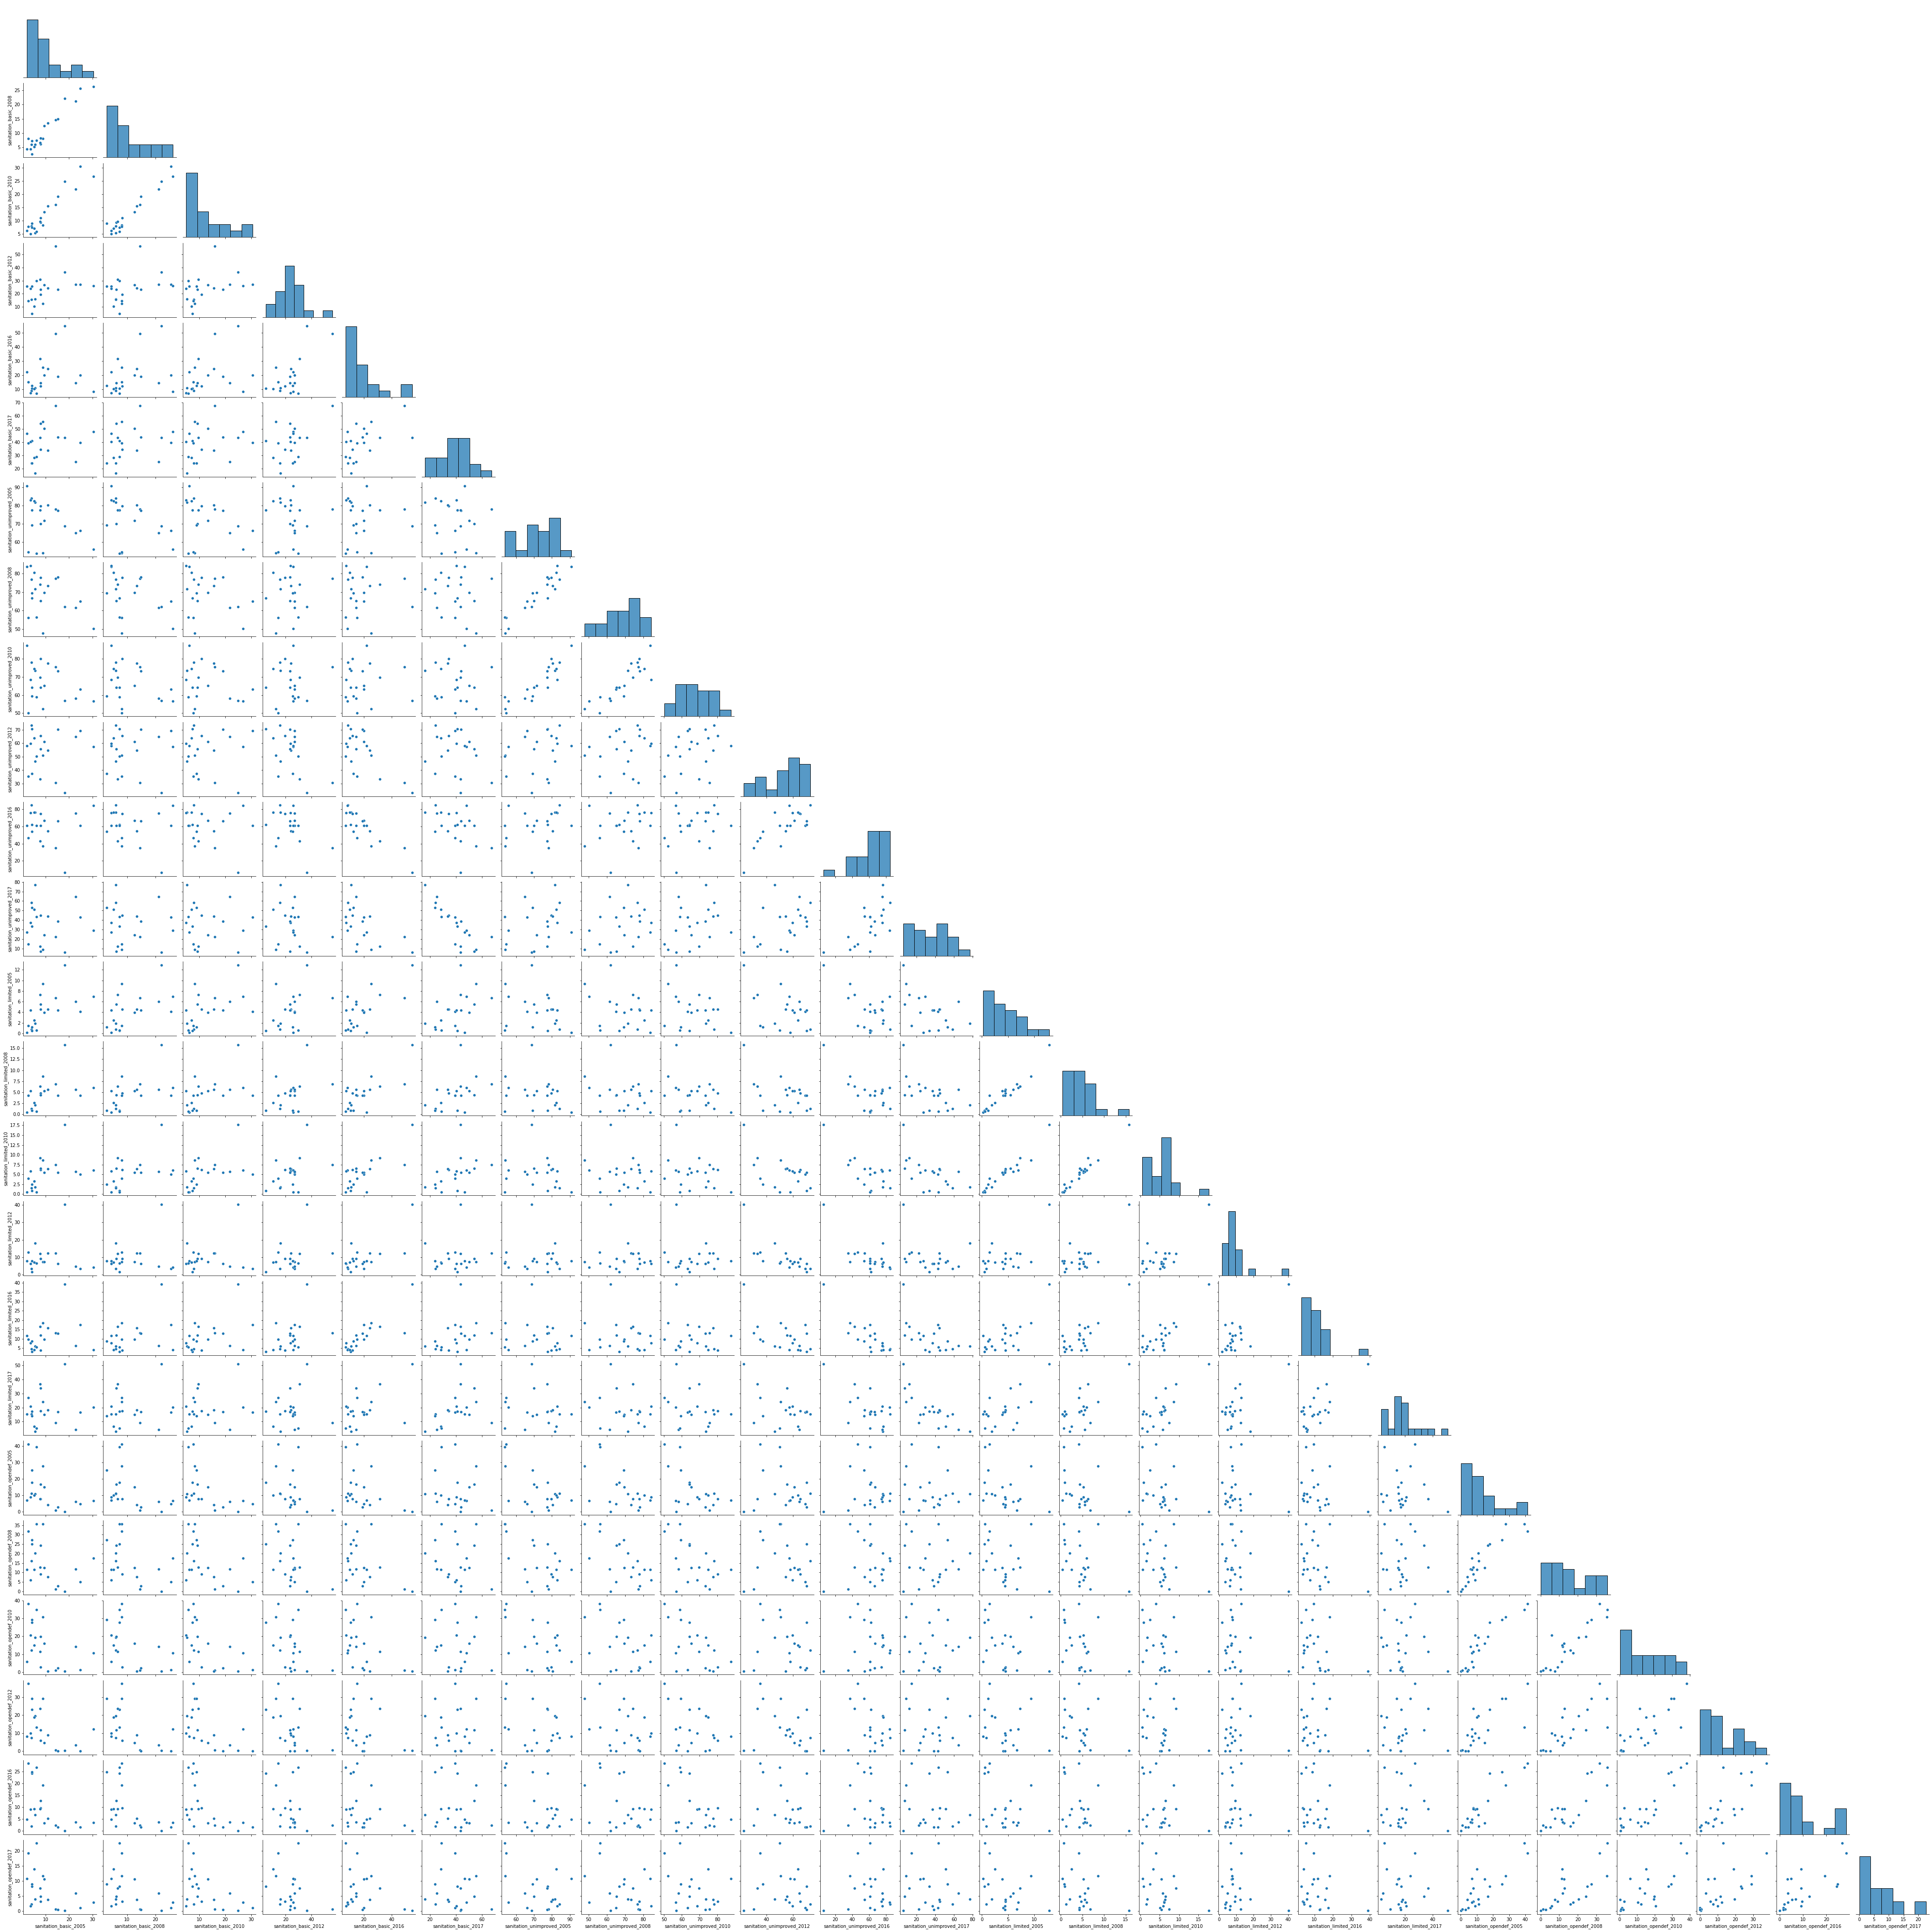

In [94]:
sns.pairplot(new_uni_df_sanitation_pre, corner=True);